In [88]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
from sklearn.metrics import classification_report
import transformation_funcs as tfs
import seaborn as sns
from torchsummary import summary
torch.cuda.set_device(1) 

In [89]:
def snomedConvert(label_df,snomed=True):
    codes =  pd.read_csv("data/snomed_codes.csv",sep=",")[["Dx","SNOMEDCTCode"]]
    if snomed:
        label_df.columns = [codes[codes["SNOMEDCTCode"] == int(x)]["Dx"].item() for x in label_df.columns]
        return label_df
DATASET_NAME = "WFDB_CPSC2018_signitured"
X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)


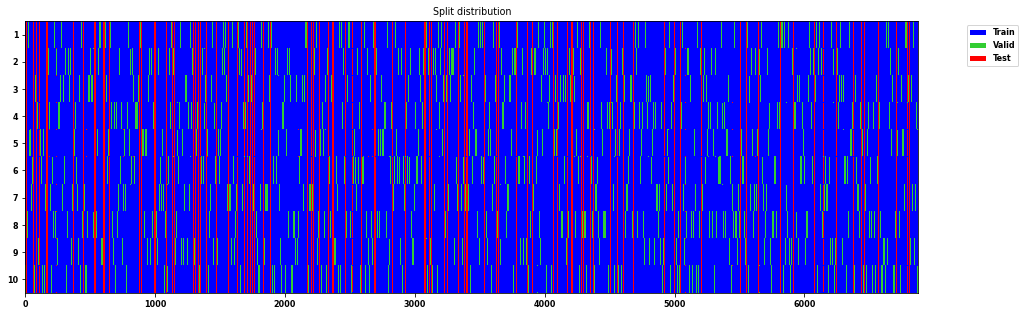

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


In [90]:

cv_splits = get_splits(y.to_numpy(), n_splits = 10, valid_size=.1,test_size=0.1, stratify=False, random_state=23, shuffle=True)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

In [ ]:
max_len = 8000
sf = 0.4
tfms  = [None, TSMultiLabelClassification()]
# batch_tfms = [
#              TSStandardize(by_sample=True),
#                 tfs.Scale(scale_factor=sf,),
#                 tfs.Normalize(),
#                 tfs.BandPass(int(sf*500),low_cut=50, high_cut=1,leads=12,),
#                 tfs.RandomShift(0.1),
#                 tfs.MulNoise(6),
#                 tfs.CutOutWhenTraining(),
#              ]
batch_tfms = [
    tfs.Normalize(),
    tfs.Scale(scale_factor=sf)
 ]
for cv_num in range(10):
    cv_num = cv_num + 0
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=cv_splits[cv_num]) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
    # model = MiniRocketPlus(dls.vars, dls.c,2500)
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=13, ks = 110,nf=28 )
    # try : loss_func = BCEWithLogitsLossFlat(pos_weight=dls.train.cws.sqrt())
    
    learn = Learner(dls, model, metrics=metrics,
#                     opt_func = wrap_optimizer(torch.optim.Adam,weight_decay=6.614e-07),
                    cbs=[ShowGraph(),fastai.callback.all.SaveModelCallback(monitor="F1_multi",fname="inception_augmented_%s_%s_nf8"%(max_len,cv_num))],
                    model_dir="models/10CV/")
    learn.fit_one_cycle(300, lr_max=0.01)
    learn.recorder.plot_metrics()

### check f1s

In [33]:

batch_tfms = [
                tfs.Normalize(),
                tfs.Scale(scale_factor=sf,),
             ]
reports = []
probas_list, targets_list = [],[]
for cv_num in range(10):
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float)[:,:,0:max_len], y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=13, ks = 110,nf=28 )
    learn = Learner(dls, model, metrics=metrics, 
                    cbs=[ShowGraph()],
                    model_dir="models/10CV/")
    learn.load("inception_augmented_%s_%s_nf8"%(max_len,cv_num))
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)
    probas_list.append(valid_probas)
    targets_list.append(valid_targets)
    y_pred = (valid_preds>0)
    y_test = valid_targets

    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    reports.append(report)

In [34]:
for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
pd.DataFrame(reports).median()

1st degree av block             0.858289
atrial fibrillation             0.933350
left bundle branch block        0.904762
premature atrial contraction    0.754447
right bundle branch block       0.940266
sinus rhythm                    0.804414
st depression                   0.810112
st elevation                    0.505814
ventricular ectopics            0.824572
micro avg                       0.860519
macro avg                       0.816885
weighted avg                    0.857700
samples avg                     0.835274
dtype: float64

In [35]:
def label_convert_ICBEB(label):
    mapping = {'1st degree av block':"I-AVB",
    'atrial fibrillation':"AF",
    'left bundle branch block':"LBBB",
    'premature atrial contraction':"PAC",
    'right bundle branch block':"RBBB",
    'sinus rhythm':"normal",
    'st depression':"STD",
    'st elevation':"STE",
    'ventricular ectopics':"PVC"}
    try: 
        return mapping[label]
    except:
        return label
df = pd.DataFrame(reports)
df.columns = [label_convert(x) for x in df.columns]
sorted(dict(df[df.columns].median()).items())

[('AF', 0.9333495373183562),
 ('I-AVB', 0.858288770053476),
 ('LBBB', 0.9047619047619047),
 ('PAC', 0.7544467544467544),
 ('PVC', 0.8245720345402212),
 ('RBBB', 0.9402660837651122),
 ('STD', 0.8101123595505617),
 ('STE', 0.5058139534883721),
 ('macro avg', 0.8168846290656202),
 ('micro avg', 0.8605188887134907),
 ('normal', 0.8044138182259728),
 ('samples avg', 0.8352741387675886),
 ('weighted avg', 0.857699902264191)]

In [36]:
winner = dict(zip(["normal","AF","I-AVB","LBBB","RBBB","PAC","PVC","STD","STE"],[0.795,0.897,0.865,0.821,0.911,0.734,0.852,0.788,0.509]))
winner_ensemble = dict(zip(["normal","AF","I-AVB","LBBB","RBBB","PAC","PVC","STD","STE"],[0.808,0.933,0.875,0.884,0.910,0.826,0.869,0.811,0.624]))
inception_no_augment = dict(zip(["RBBB","PVC","AF","LBBB","STE","I-AVB","PAC","normal","STD"],[0.944,0.715,0.939,0.891,0.482,0.833,0.505, 0.709,0.789]))
# inception_augmented = dict(zip(["RBBB","PVC","AF","LBBB","STE","I-AVB","PAC","normal","STD"],[0.935,0.682,0.944,0.884,0.450,0.846,0.474, 0.731,0.778]))
inception_augmented = dict({('AF', 0.9333495373183562),
 ('I-AVB', 0.858288770053476),
 ('LBBB', 0.9047619047619047),
 ('PAC', 0.7544467544467544),
 ('PVC', 0.8245720345402212),
 ('RBBB', 0.9402660837651122),
 ('STD', 0.8101123595505617),
 ('STE', 0.5058139534883721),
 ('normal', 0.8044138182259728),})
inception_scaled_only = dict({
                        'I-AVB': 0.8464646464646466,
                         'AF': 0.9429286608260325,
                         'LBBB': 0.8717948717948718,
                         'PAC': 0.454995499549955,
                         'RBBB': 0.9367724233463863,
                         'normal': 0.6970246316758748,
                         'STD': 0.765686274509804,
                         'STE': 0.46785225718194257,
                         'PVC': 0.68630634479812,})
inception_normal_only = dict({
                            'I-AVB': 0.8464646464646466,
                             'AF': 0.9305368413587689,
                             'LBBB': 0.8717948717948718,
                             'PAC': 0.38829471182412356,
                             'RBBB': 0.9354067624592703,
                             'normal': 0.7190058479532164,
                             'STD': 0.7508747606786823,
                             'STE': 0.43843843843843844,
                             'PVC': 0.6731462086300797,
                        })

winner = dict(sorted(winner.items()))
winner_ensemble = dict(sorted(winner_ensemble.items()))
# inception = dict(sorted(inception.items()))
inception_augmented = dict(sorted(inception_augmented.items()))
df = pd.DataFrame([winner_ensemble,winner,inception_augmented,inception_scaled_only,inception_normal_only],index=["winner_ensemble","winner","inception_augmented","inception_scaled_only","inception_normal_only"]).T
df["performance"] = df["winner"]<df["inception_augmented"]
df

,winner_ensemble,winner,inception_augmented,inception_scaled_only,inception_normal_only,performance
AF,0.933,0.897,0.933350,0.942929,0.930537,True
I-AVB,0.875,0.865,0.858289,0.846465,0.846465,False
LBBB,0.884,0.821,0.904762,0.871795,0.871795,True
PAC,0.826,0.734,0.754447,0.454995,0.388295,True
PVC,0.869,0.852,0.824572,0.686306,0.673146,False
RBBB,0.910,0.911,0.940266,0.936772,0.935407,True
STD,0.811,0.788,0.810112,0.765686,0.750875,True
STE,0.624,0.509,0.505814,0.467852,0.438438,False
normal,0.808,0.795,0.804414,0.697025,0.719006,True


In [37]:
df.mean()

winner_ensemble          0.837778
winner                   0.796889
inception_augmented      0.815114
inception_scaled_only    0.741092
inception_normal_only    0.728218
performance              0.666667
dtype: float64

In [87]:
aucs

[['left bundle branch block', 0.9985029940119761],
 ['atrial fibrillation', 0.9910018720937255],
 ['right bundle branch block', 0.9901959765576291],
 ['1st degree av block', 0.9786640426024543],
 ['sinus rhythm', 0.9774137931034483],
 ['st depression', 0.9712107727431026],
 ['ventricular ectopics', 0.9621397166585247],
 ['premature atrial contraction', 0.9409622541201489],
 ['st elevation', 0.9362116641528406]]

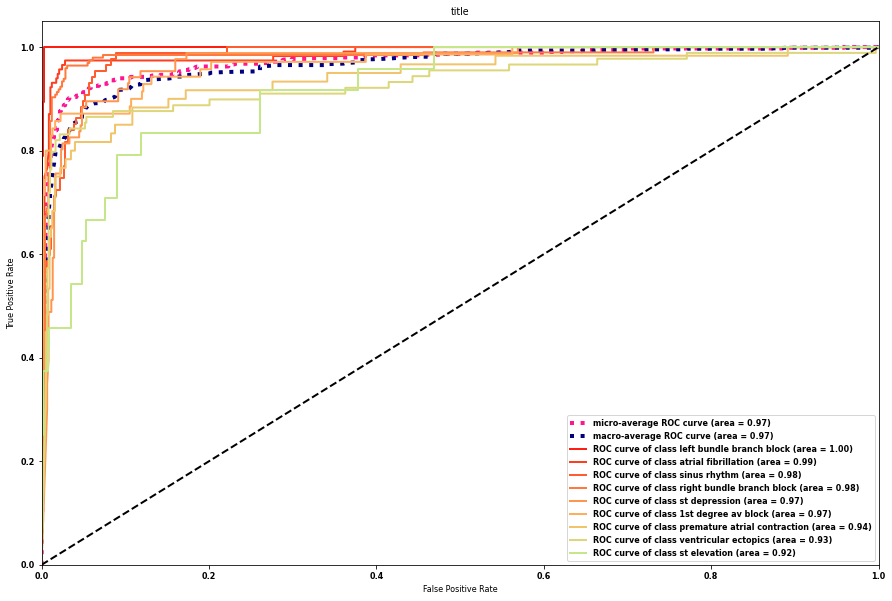

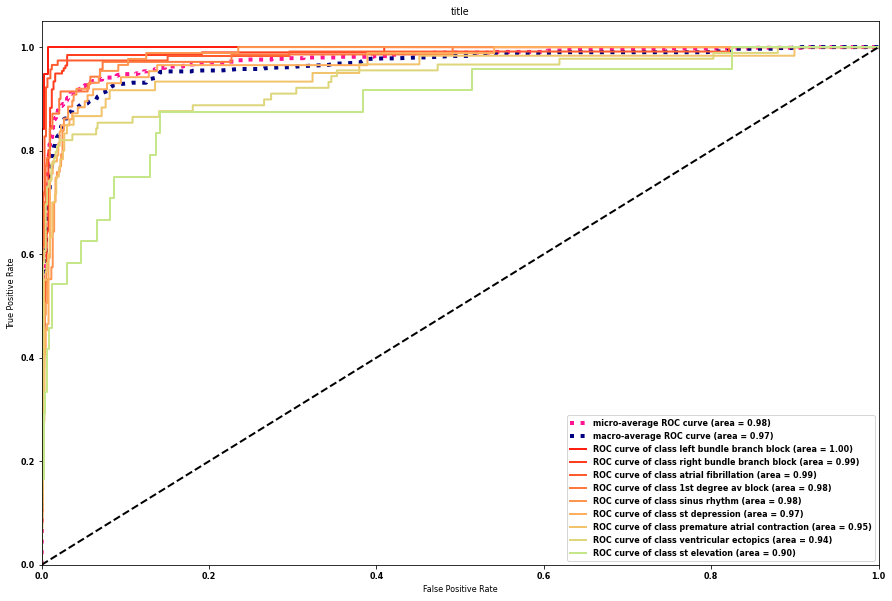

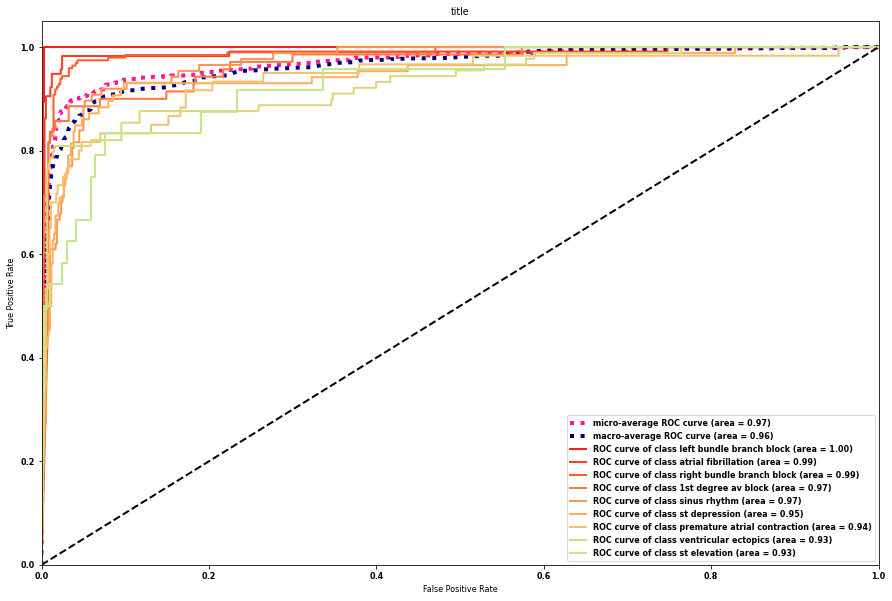

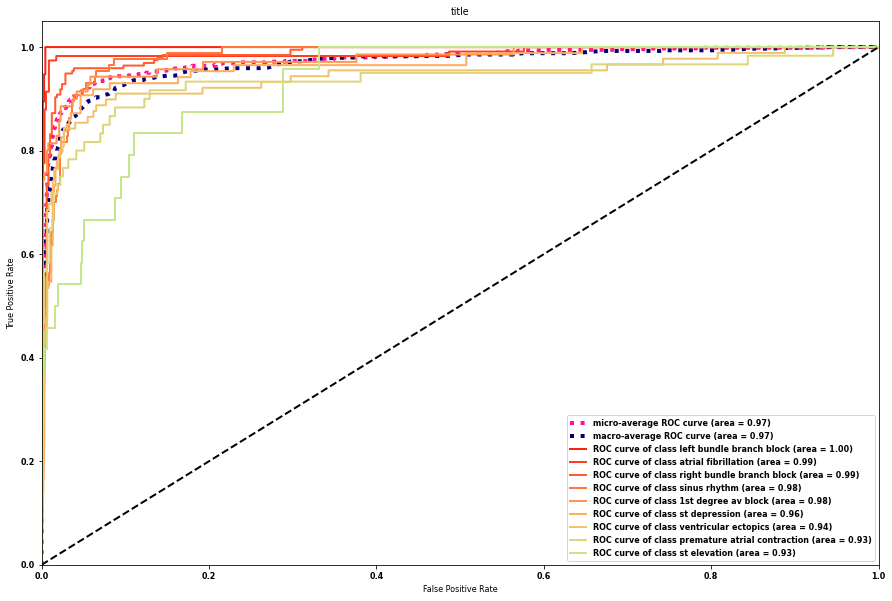

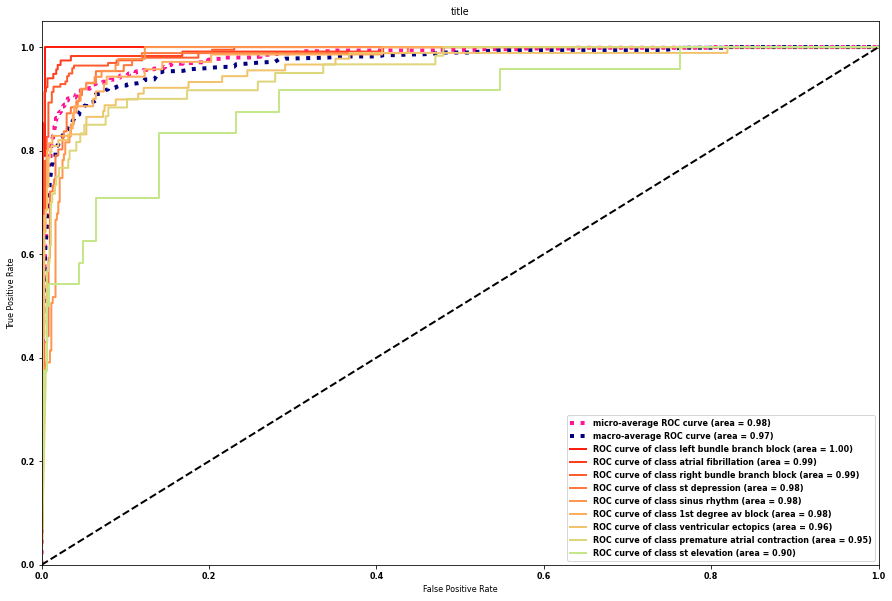

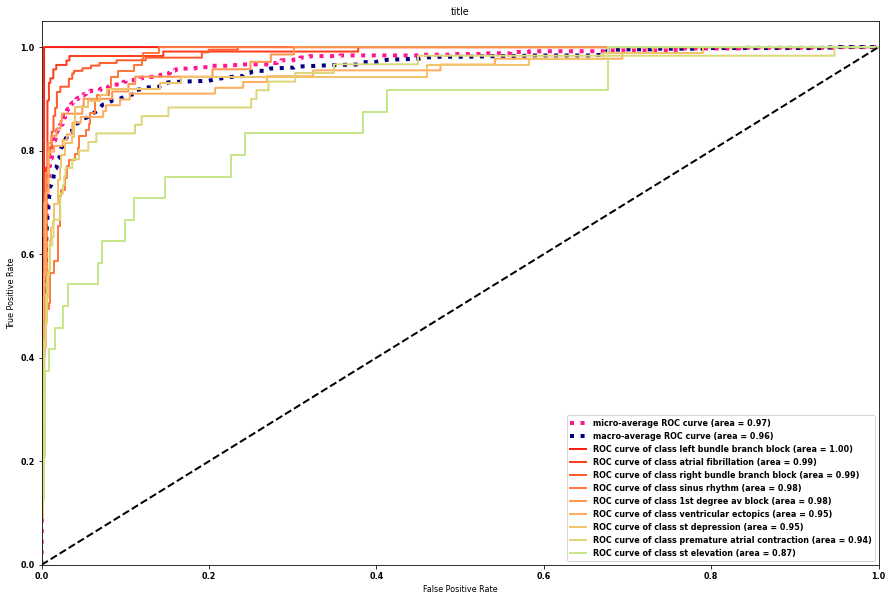

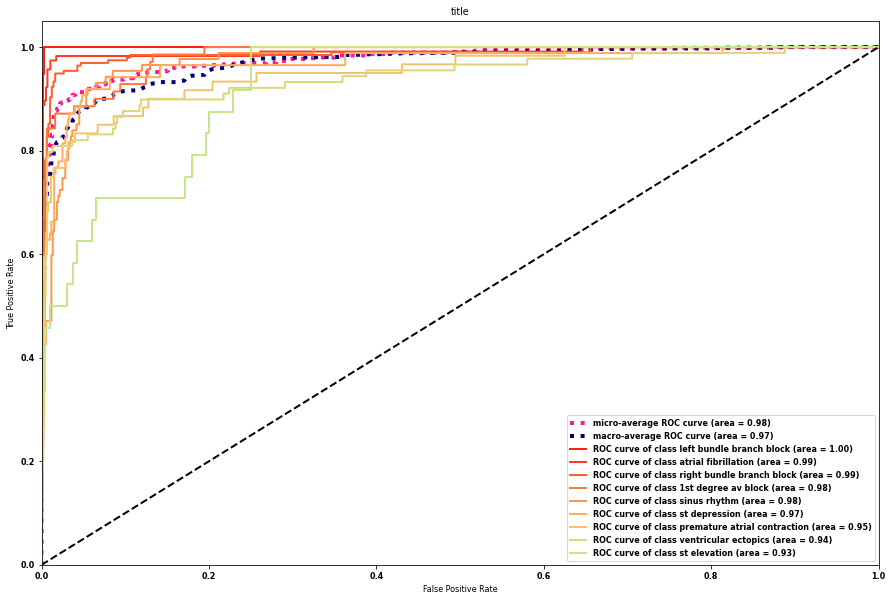

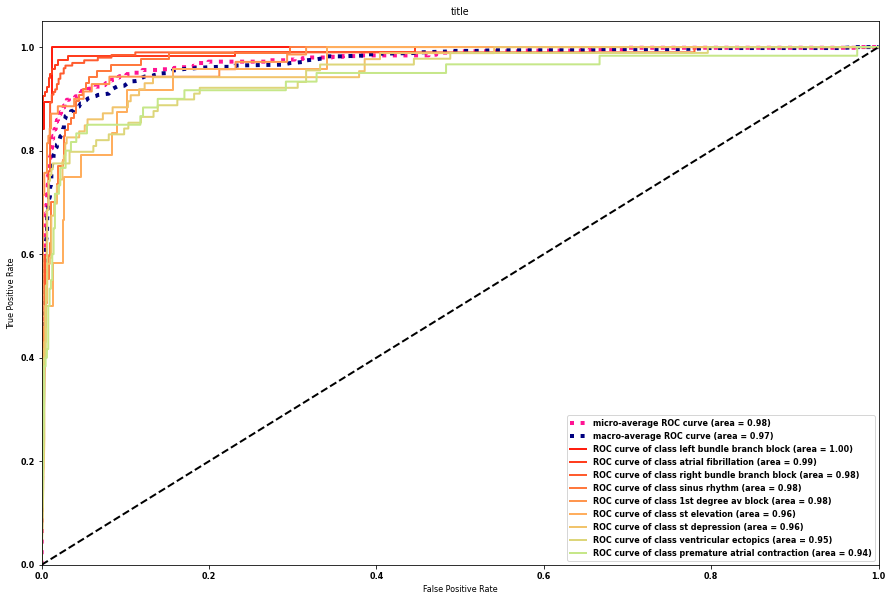

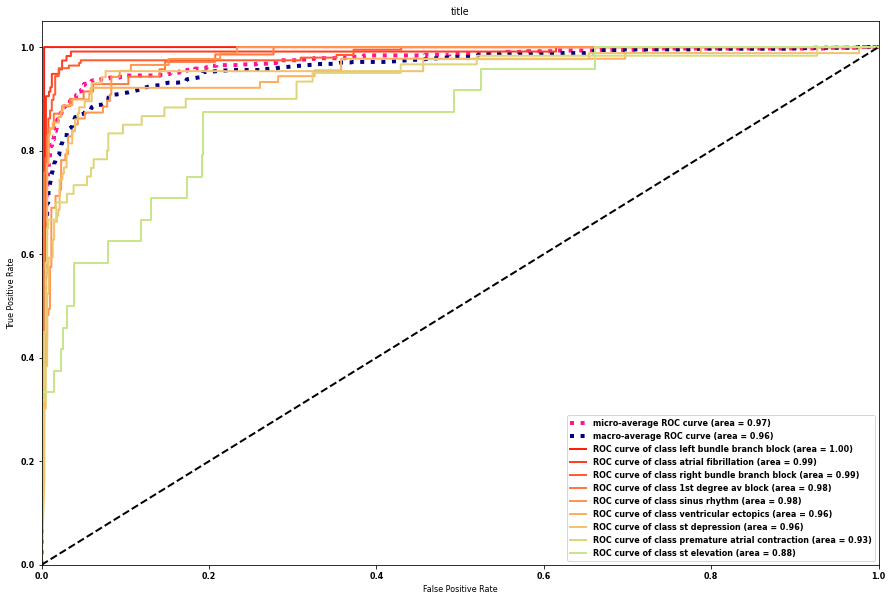

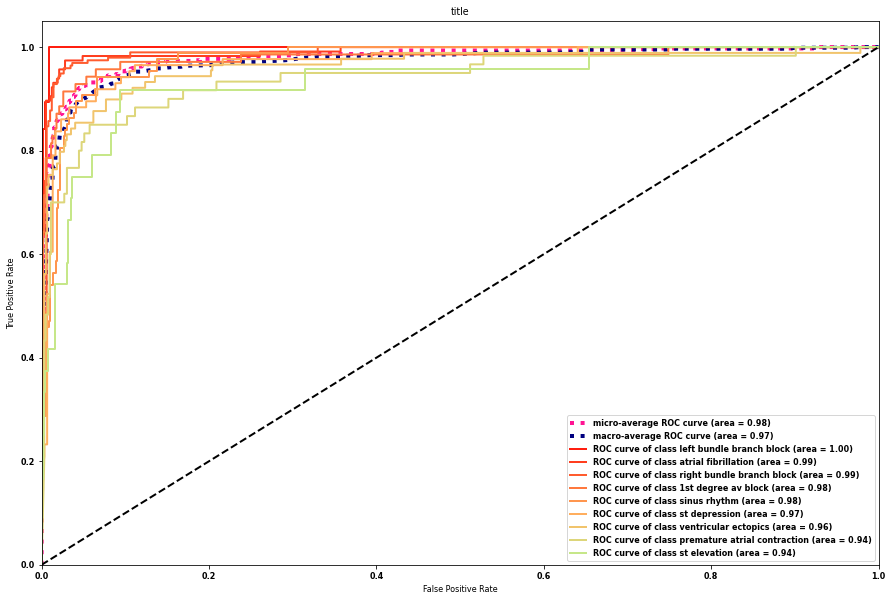

In [76]:
import amir_tools as at

aucs_list = []
for targets,probs in zip(targets_list,probas_list):
    fig, aucs = at.draw_aucs(targets,probs,list(dls.vocab.o2i.keys()))
    aucs_list.append(dict(aucs))

,left bundle branch block,atrial fibrillation,sinus rhythm,right bundle branch block,st depression,1st degree av block,premature atrial contraction,ventricular ectopics,st elevation
0,0.999527,0.987341,0.983602,0.983395,0.970301,0.970259,0.940032,0.933035,0.917295
1,0.999291,0.986971,0.982653,0.989027,0.970775,0.982913,0.952897,0.938268,0.895739
2,0.999370,0.988375,0.969310,0.985504,0.947152,0.969669,0.940298,0.932659,0.929676
3,0.998661,0.989598,0.982797,0.986268,0.963375,0.976314,0.934862,0.943106,0.930430
4,0.998976,0.992866,0.980661,0.990627,0.980739,0.979486,0.954306,0.962262,0.895488
5,0.998700,0.992006,0.977529,0.988102,0.951225,0.976175,0.937959,0.952698,0.865573
6,0.999685,0.990541,0.976590,0.985577,0.969615,0.983943,0.951834,0.942975,0.927476
7,0.998582,0.993131,0.981801,0.984813,0.958857,0.979567,0.936417,0.947663,0.959779
8,0.998858,0.990247,0.976810,0.986492,0.955868,0.982971,0.933759,0.959199,0.877828
9,0.998503,0.991002,0.977414,0.990196,0.971211,0.978664,0.940962,0.962140,0.936212
